In [53]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
df = pd.read_csv('weather_data.csv')
df

C:\Users\danza\AppData\Local\Temp\ipykernel_8732\356624081.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('weather_data.csv')


,Location,Date_Time,Temperature_C
0,NaN,NaN,NaN
1,San Diego,2024-01-14 21:12:46,10.0
2,San Diego,2024-05-17 15:22:10,8.0
3,San Diego,2024-05-11 09:30:59,11.0
4,Philadelphia,2024-02-26 17:32:39,-8.0
...,...,...,...
1829996,San Diego,2024-01-14 21:12:46,10.0
1829997,San Diego,2024-01-14 21:12:46,10.0
1829998,San Diego,2024-01-14 21:12:46,10.0
1829999,San Diego,2024-01-14 21:12:46,10.0


In [55]:
df.shape

(1830001, 3)

In [56]:
df.dtypes

Location          object
Date_Time         object
Temperature_C    float64
dtype: object

In [57]:
df.describe()

,Temperature_C
count,1.150000e+06
mean,1.389953e+01
std,1.332888e+01
min,-1.900000e+01
25%,4.000000e+00
50%,1.100000e+01
75%,2.500000e+01
max,3.900000e+01


In [58]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df['Temperature_C'] = pd.to_numeric(df['Temperature_C'])
df.dtypes

Location                 object
Date_Time        datetime64[ns]
Temperature_C           float64
dtype: object

In [59]:
# Считывание и процессинг
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[pd.to_numeric(df['Temperature_C'], errors='coerce').notnull()]

In [60]:
df.set_index('Date_Time', inplace=True)
df = df.between_time('3:00', '0:59')

In [61]:
# Расчет метрик
def f(x):
    d = {}
    d['location_count_distinct'] = x['Location'].nunique()
    d['temp_mean'] = x['Temperature_C'].mean()
    d['temp_median'] = x['Temperature_C'].median()
    return pd.Series(d, index=['location_count_distinct', 'temp_mean', 'temp_median'])

grouped_by_hour = df.groupby(df.index.hour).apply(f)
grouped_by_hour.index.names = ['hour']
grouped_by_hour

# select date_part('hour', date_time), 
# count(distinct location) as location_count_distinct,
# avg(temperature_c) as temp_mean,
# percentile_cont(0.5) within group(order by temperature_c) as temp_median
# from source
# group by date_part('hour', date_time)

,location_count_distinct,temp_mean,temp_median
hour,,,
0,10.0,14.504115,14.0
3,10.0,14.516970,14.0
4,10.0,14.449497,14.0
5,10.0,14.514676,14.0
6,10.0,14.473851,14.0
7,10.0,14.526229,14.0
8,10.0,14.473033,14.0
9,10.0,14.514428,14.0
10,10.0,14.442985,14.0


In [62]:
# Мерж с метриками
df['hour'] = df.index.round('h').hour

df.reset_index().set_index('hour', inplace=True)
df_merged = df.merge(grouped_by_hour, how='left', on='hour')
df = df.reset_index()
df.drop(columns=['hour'], inplace=True)

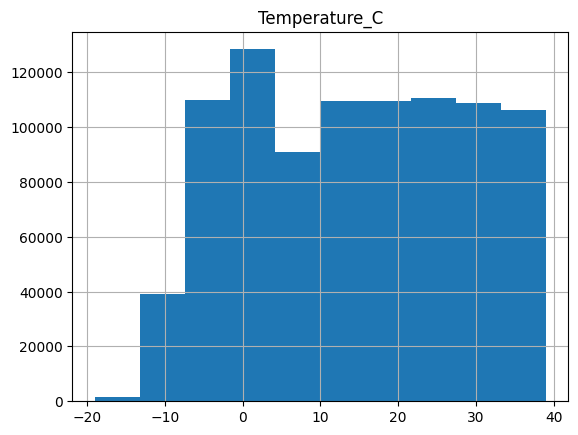

In [63]:
# Аналитические метрики
hist = df.hist(column='Temperature_C')

<BarContainer object of 5 artists>

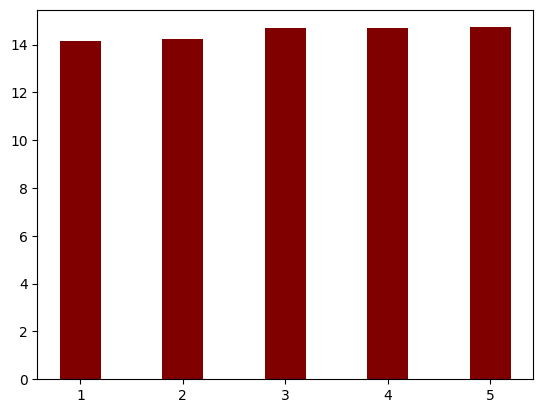

In [64]:
# Визуализация
grouped_by_month = df.groupby(df['Date_Time'].dt.month)['Temperature_C'].mean()
plt.bar(grouped_by_month.index, grouped_by_month.values,color ='maroon', 
        width = 0.4)

In [65]:
unique_locs = df['Location'].unique()
unique_locs
symbols_array = []
for loc in unique_locs:
    symbols_array.extend(list(loc))
symbols_array
symbols = pd.Series(symbols_array)
symbols = symbols.unique()
symbols_count_dict = {}
for symbol in symbols:
    symbols_count_dict[symbol] = df[df['Location'].str.find(symbol)!=-1]['Location'].count()
symbols_count_dict

symbols_count = pd.DataFrame.from_dict(symbols_count_dict, orient='index')

<Axes: >

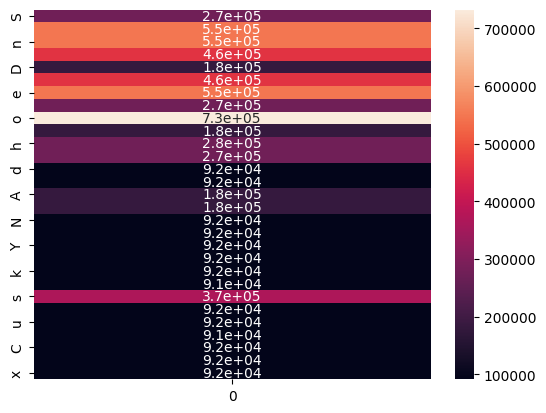

In [66]:
symbols_count

sns.heatmap(symbols_count, annot=True)